**MS Classification Code**

In [ ]:
# kagglehub library used to interface with Kaggle and download datasets programmatically.
import kagglehub

# Description:
# Downloads MRI brain scans dataset from Kaggle.
# Dataset URL: https://www.kaggle.com/datasets/omarradi1993/mri-scans-brain-neurological-classes

try:
    # Download the dataset and store the local path
    OmarRadi_MRIScans = kagglehub.dataset_download('omarradi1993/mri-scans-brain-neurological-classes')

    print('Data source import completed.')
    print(f'Dataset saved to: (OmarRadi_MRIScans)')

except Exception as e:
    print('Failed to download dataset.')
    print(f'Error: {e}')

100%|██████████| 503M/503M [00:10<00:00, 50.0MB/s]

Extracting files...


Data source import completed.
Dataset saved to: (OmarRadi_MRIScans)


In [ ]:
# To see what files are downloaded:
import os

# Check if the dataset path exists before listing files
if OmarRadi_MRIScans and os.path.exists(OmarRadi_MRIScans):
    print("Downloaded files:")
    for file_name in os.listdir(OmarRadi_MRIScans):
        print(f"- {file_name}")
else:
    print("Dataset path is invalid or not found.")

Downloaded files:
- BT_pituitary
- AD_MildDemented
- BT_meningioma
- MS
- BT_glioma
- Normal
- AD_ModerateDemented
- AD_VeryMildDemented


<div style='background-color: #e6f7ff; border: 3px solid #0078FF; border-radius: 10px; padding: 8px; text-align: center;'>
    <font size="+2" color="#0078FF"><b>🗂️ 1. Custom Datasets & DataLoaders 🗂️</b></font>
</div>

In [ ]:
# Os Means (Miscellaneous operating system interfaces). The OS module in Python is part of the programming language's standard library.
# When imported, it lets the user interact with the native OS Python is currently running on.
# In simple terms, it provides an easy way for the user to interact with several os functions that come in handy in day to day programming
import os

# PyTorch is a Python package that provides two high-level features:
# 1- Tensor computation (like NumPy) with strong GPU acceleration
# 2- Deep neural networks built on a tape-based autograd system
import torch

# Utilizing the import numpy as np statement simplifies integrating the NumPy library into Python scripts or interactive environments.
# The adoption of the widely accepted alias "np" enhances code readability and conciseness.
import numpy as np

# The glob module in Python is used to search for file path names that match a specific pattern.
# It includes the glob.glob() and glob.iglob() functions, and can be helpful when searching CSV files and for text in files.
from glob import glob

# PIL is the (Python Imaging Library) which provides the python interpreter with image editing capabilities.
# The Image module provides a class with the same name which is used to represent a PIL image
from PIL import Image

# Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
# The DataLoader supports both map-style and iterable-style datasets with single- or multi-process loading,
# customizing loading order and optional automatic batching (collation) and memory pinning
from torch.utils.data import random_split, Dataset, DataLoader

# Performs a random perspective transformation of the given image with a given probability.
# If the image is torch Tensor, it is expected to have […, H, W] shape, where means an arbitrary number of leading dimensions.
from torchvision import transforms as T

torch.manual_seed(2025)

class CustomDataset(Dataset):
    def __init__(self, root, transformations=None, im_files=[".png", ".jpg", ".jpeg", ".bmp"]):
        self.transformations = transformations
        # Updated to correctly search for files within the extracted Kaggle dataset
        self.im_paths = []
        for ext in im_files:
            self.im_paths.extend(glob(os.path.join(root, "**", f"*{ext}"), recursive=True))

        if len(self.im_paths) == 0:
            raise ValueError("No images found. Check your dataset path or image extensions.")

        self.cls_names, self.cls_counts = {}, {}
        count = 0
        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.basename(os.path.dirname(path))

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]
        if self.transformations is not None:
            im = self.transformations(im)
        return im, gt

    @classmethod
    def get_dls(cls, root, transformations, bs, split=[0.9, 0.05, 0.05], ns=2):
        ds = cls(root=root, transformations=transformations)
        total_len = len(ds)

        tr_len = int(total_len * split[0])
        vl_len = int(total_len * split[1])
        ts_len = total_len - (tr_len + vl_len)

        # Fix mismatch if rounding causes off-by-one error
        if tr_len + vl_len + ts_len != total_len:
            ts_len = total_len - (tr_len + vl_len)

        tr_ds, vl_ds, ts_ds = random_split(ds, [tr_len, vl_len, ts_len])

        tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
        val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns)
        ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)

        return tr_dl, val_dl, ts_dl, ds.cls_names, ds.cls_counts

# Assuming OmarRadi_MRIScans is the correct path from your kagglehub download
root = OmarRadi_MRIScans
#root = "/content/mcnd-dataset"  # Previous Incorrect Path

mean, std, im_size, bs = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 128, 32
tfs = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# Get the dataloaders
tr_dl, val_dl, ts_dl, classes, cls_counts = CustomDataset.get_dls(root=root, transformations=tfs, bs=bs)

# Print dataset summary
print(f"Train batches: {len(tr_dl)}")
print(f"Validation batches: {len(val_dl)}")
print(f"Test batches: {len(ts_dl)}")
print(f"Classes: {classes}")

Train batches: 462
Validation batches: 26
Test batches: 820
Classes: {'MS': 0, 'Normal': 1, 'BT_pituitary': 2, 'AD_MildDemented': 3, 'BT_meningioma': 4, 'BT_glioma': 5, 'AD_ModerateDemented': 6, 'AD_VeryMildDemented': 7}


In [ ]:
import os
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

class CustomDataset(Dataset):
    """
    Custom PyTorch Dataset for loading images from a root directory where each subdirectory
    corresponds to a class name.
    """

    def __init__(self, root, transformations=None, im_extensions=(".png", ".jpg", ".jpeg", ".bmp")):
        """
        Initializes the dataset by listing all image paths and mapping class names to labels.

        Args:
            root (str): Root directory path.
            transformations (callable, optional): Transformations to apply to the images.
            im_extensions (tuple): Tuple of allowed image file extensions.
        """
        self.transformations = transformations
        # Get all image paths matching the allowed extensions
        self.im_paths = []
        for ext in im_extensions:
            self.im_paths.extend(glob(os.path.join(root, "*", f"*{ext}")))

        # Create class name to label mapping and count samples per class
        self.cls_names = {}   # class name -> label
        self.cls_counts = {}  # class name -> count
        label_id = 0
        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = label_id
                self.cls_counts[class_name] = 1
                label_id += 1
            else:
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        """Extracts the class name from the image path."""
        return os.path.basename(os.path.dirname(path))

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.im_paths)

    def __getitem__(self, idx):
        """Loads and returns an image and its label."""
        im_path = self.im_paths[idx]
        image = Image.open(im_path).convert("RGB")
        label = self.cls_names[self.get_class(im_path)]

        if self.transformations:
            image = self.transformations(image)

        return image, label

    @classmethod
    def get_dls(cls, root, transformations, bs, split=(0.9, 0.05, 0.05), num_workers=4):
        """
        Creates and returns train, validation, and test DataLoaders.

        Args:
            root (str): Dataset root directory.
            transformations (callable): Image transformations.
            bs (int): Batch size.
            split (tuple): Split proportions for train, val, and test sets.
            num_workers (int): Number of subprocesses to use for data loading.

        Returns:
            tuple: (train_loader, val_loader, test_loader, class_names, class_counts)
        """
        dataset = cls(root=root, transformations=transformations)

        total_len = len(dataset)
        tr_len = int(total_len * split[0])
        val_len = int(total_len * split[1])
        ts_len = total_len - (tr_len + val_len)

        # Ensure at least one sample in the test set
        if ts_len < 1:
            if tr_len > 1:
                tr_len -= 1 - ts_len
            elif val_len > 1:
                val_len -= 1 - ts_len
            ts_len = 1

        tr_ds, val_ds, ts_ds = random_split(dataset, [tr_len, val_len, ts_len])

        tr_loader = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
        val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=num_workers)
        ts_loader = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=num_workers)

        return tr_loader, val_loader, ts_loader, dataset.cls_names, dataset.cls_counts


# ==== USAGE EXAMPLE ====
root = OmarRadi_MRIScans

# Normalization parameters (ImageNet-style) and image size
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
im_size = 128
batch_size = 32

# Define the transformations pipeline
transformations = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# Get DataLoaders and class information
tr_dl, val_dl, ts_dl, classes, cls_counts = CustomDataset.get_dls(
    root=root,
    transformations=transformations,
    bs=batch_size
)

# Print basic information
print(f"Train Loader Batches: {len(tr_dl)}")
print(f"Validation Loader Batches: {len(val_dl)}")
print(f"Test Loader Batches: {len(ts_dl)}")
print("Classes:", classes)

Train Loader Batches: 462
Validation Loader Batches: 26
Test Loader Batches: 820
Classes: {'MS': 0, 'Normal': 1, 'BT_pituitary': 2, 'AD_MildDemented': 3, 'BT_meningioma': 4, 'BT_glioma': 5, 'AD_ModerateDemented': 6, 'AD_VeryMildDemented': 7}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


<div style='background-color: #ffe6f2; border: 3px solid #ff1493; border-radius: 10px; padding: 8px; text-align: center;'>
    <font size="+2" color="#ff1493"><b>📈 2. Data Analysis 📈</b></font>
</div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
import random

class Visualization:
    """
    A class to visualize image samples and analyze class distributions
    for datasets typically used in image classification tasks.
    """

    def __init__(self, vis_dataloaders, n_images, rows, cmap="rgb",
                 cls_names=None, cls_counts=None, t_type="rgb", seed=None):
        """
        Args:
            vis_dataloaders (list): List of DataLoaders (train, val, test).
            n_images (int): Number of images to visualize per set.
            rows (int): Number of rows in the plot grid.
            cmap (str): Color mode ("rgb" or "gray").
            cls_names (list): List of class name strings.
            cls_counts (dict or list): Class count dictionary or list of dictionaries.
            t_type (str): Normalization type ("rgb" or "gray").
            seed (int, optional): Random seed for reproducibility.
        """
        self.n_images = n_images
        self.rows = rows
        self.t_type = t_type
        self.cmap = cmap
        self.cls_names = cls_names

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        data_keys = ["train", "val", "test"]
        self.vis_dataloaders = {
            data_keys[i]: vis_dataloaders[i]
            for i in range(len(vis_dataloaders))
        }

        if isinstance(cls_counts, list):
            self.analysis_data = {
                data_keys[i]: cls_counts[i]
                for i in range(len(cls_counts))
            }
        else:
            self.analysis_data = {"all": cls_counts}

    def tn_to_np(self, tensor):
        """
        Convert a normalized tensor image to a NumPy array.
        """
        if self.t_type == "gray":
            inv_trans = T.Compose([
                T.Normalize(mean=[0.], std=[1/0.5]),
                T.Normalize(mean=[-0.5], std=[1])
            ])
            np_image = (inv_trans(tensor) * 255).detach().squeeze().cpu().numpy().astype(np.uint8)
        else:
            inv_trans = T.Compose([
                T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
                T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
            ])
            np_image = (inv_trans(tensor) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)

        return np_image

    def visualize_images(self, dataloader, title_prefix):
        """
        Plot random samples from a DataLoader.
        """
        print(f"{title_prefix.upper()} Data Visualization in process...\n")
        assert self.cmap in ["rgb", "gray"], "cmap must be 'rgb' or 'gray'"

        dataset = dataloader.dataset
        total_samples = len(dataset)
        n_samples = min(self.n_images, total_samples)
        indices = np.random.choice(total_samples, n_samples, replace=False)

        cols = (n_samples + self.rows - 1) // self.rows
        plt.figure(figsize=(4 * cols, 4 * self.rows))

        for idx, sample_idx in enumerate(indices):
            image, label = dataset[sample_idx]
            plt.subplot(self.rows, cols, idx + 1)
            np_img = self.tn_to_np(image)
            plt.imshow(np_img, cmap="gray" if self.cmap == "gray" else None)
            plt.axis("off")
            title = f"GT → {self.cls_names[int(label)]}" if self.cls_names else f"GT → {label}"
            plt.title(title)

        plt.tight_layout()
        plt.show()

    def plot_bar_chart(self, class_counts, title_suffix):
        """
        Plot a bar chart showing class distribution.
        """
        print("Data analysis in process...\n")
        class_names = list(class_counts.keys())
        counts = list(class_counts.values())

        indices = np.arange(len(counts))
        bar_width = 0.7

        plt.figure(figsize=(20, 10))
        plt.bar(indices, counts, width=bar_width, color="darkorange")
        plt.xlabel("Class Names", color="black")
        plt.ylabel("Data Counts", color="black")
        plt.title(f"{title_suffix.capitalize()} Dataset Class Distribution")
        plt.xticks(indices, class_names, rotation=90)

        for i, v in enumerate(counts):
            plt.text(i - 0.3, v + max(counts) * 0.01, str(v), color="royalblue")

        plt.tight_layout()
        plt.show()

    def plot_pie_chart(self, class_counts):
        """
        Plot a pie chart for class distribution.
        """
        print("Generating pie chart...\n")
        labels = list(class_counts.keys())
        sizes = list(class_counts.values())
        explode = [0.1] * len(labels)

        # Generate distinct colors even if >20 classes
        cmap = plt.get_cmap("tab20")
        colors = [cmap(i % 20) for i in range(len(labels))]

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
                startangle=140, colors=colors)
        plt.title("Class Distribution")
        plt.axis("equal")
        plt.show()

    def show_all_visualizations(self):
        """Visualize images from all available dataloaders."""
        for name, dataloader in self.vis_dataloaders.items():
            if dataloader is not None:
                self.visualize_images(dataloader, name)

    def show_all_class_analysis(self):
        """Show bar charts for class counts."""
        for name, counts in self.analysis_data.items():
            if counts:
                self.plot_bar_chart(counts, name)

    def show_pie_charts(self):
        """Show pie charts for class counts."""
        for counts in self.analysis_data.values():
            if counts:
                self.plot_pie_chart(counts)


<div style='background-color: #e6f7ff; border: 3px solid #007acc; border-radius: 10px; padding: 8px; text-align: center;'>
    <font size="+2" color="#007acc"><b>📊 3. Data Visualization 📊</b></font>
</div>

TRAIN Data Visualization in process...



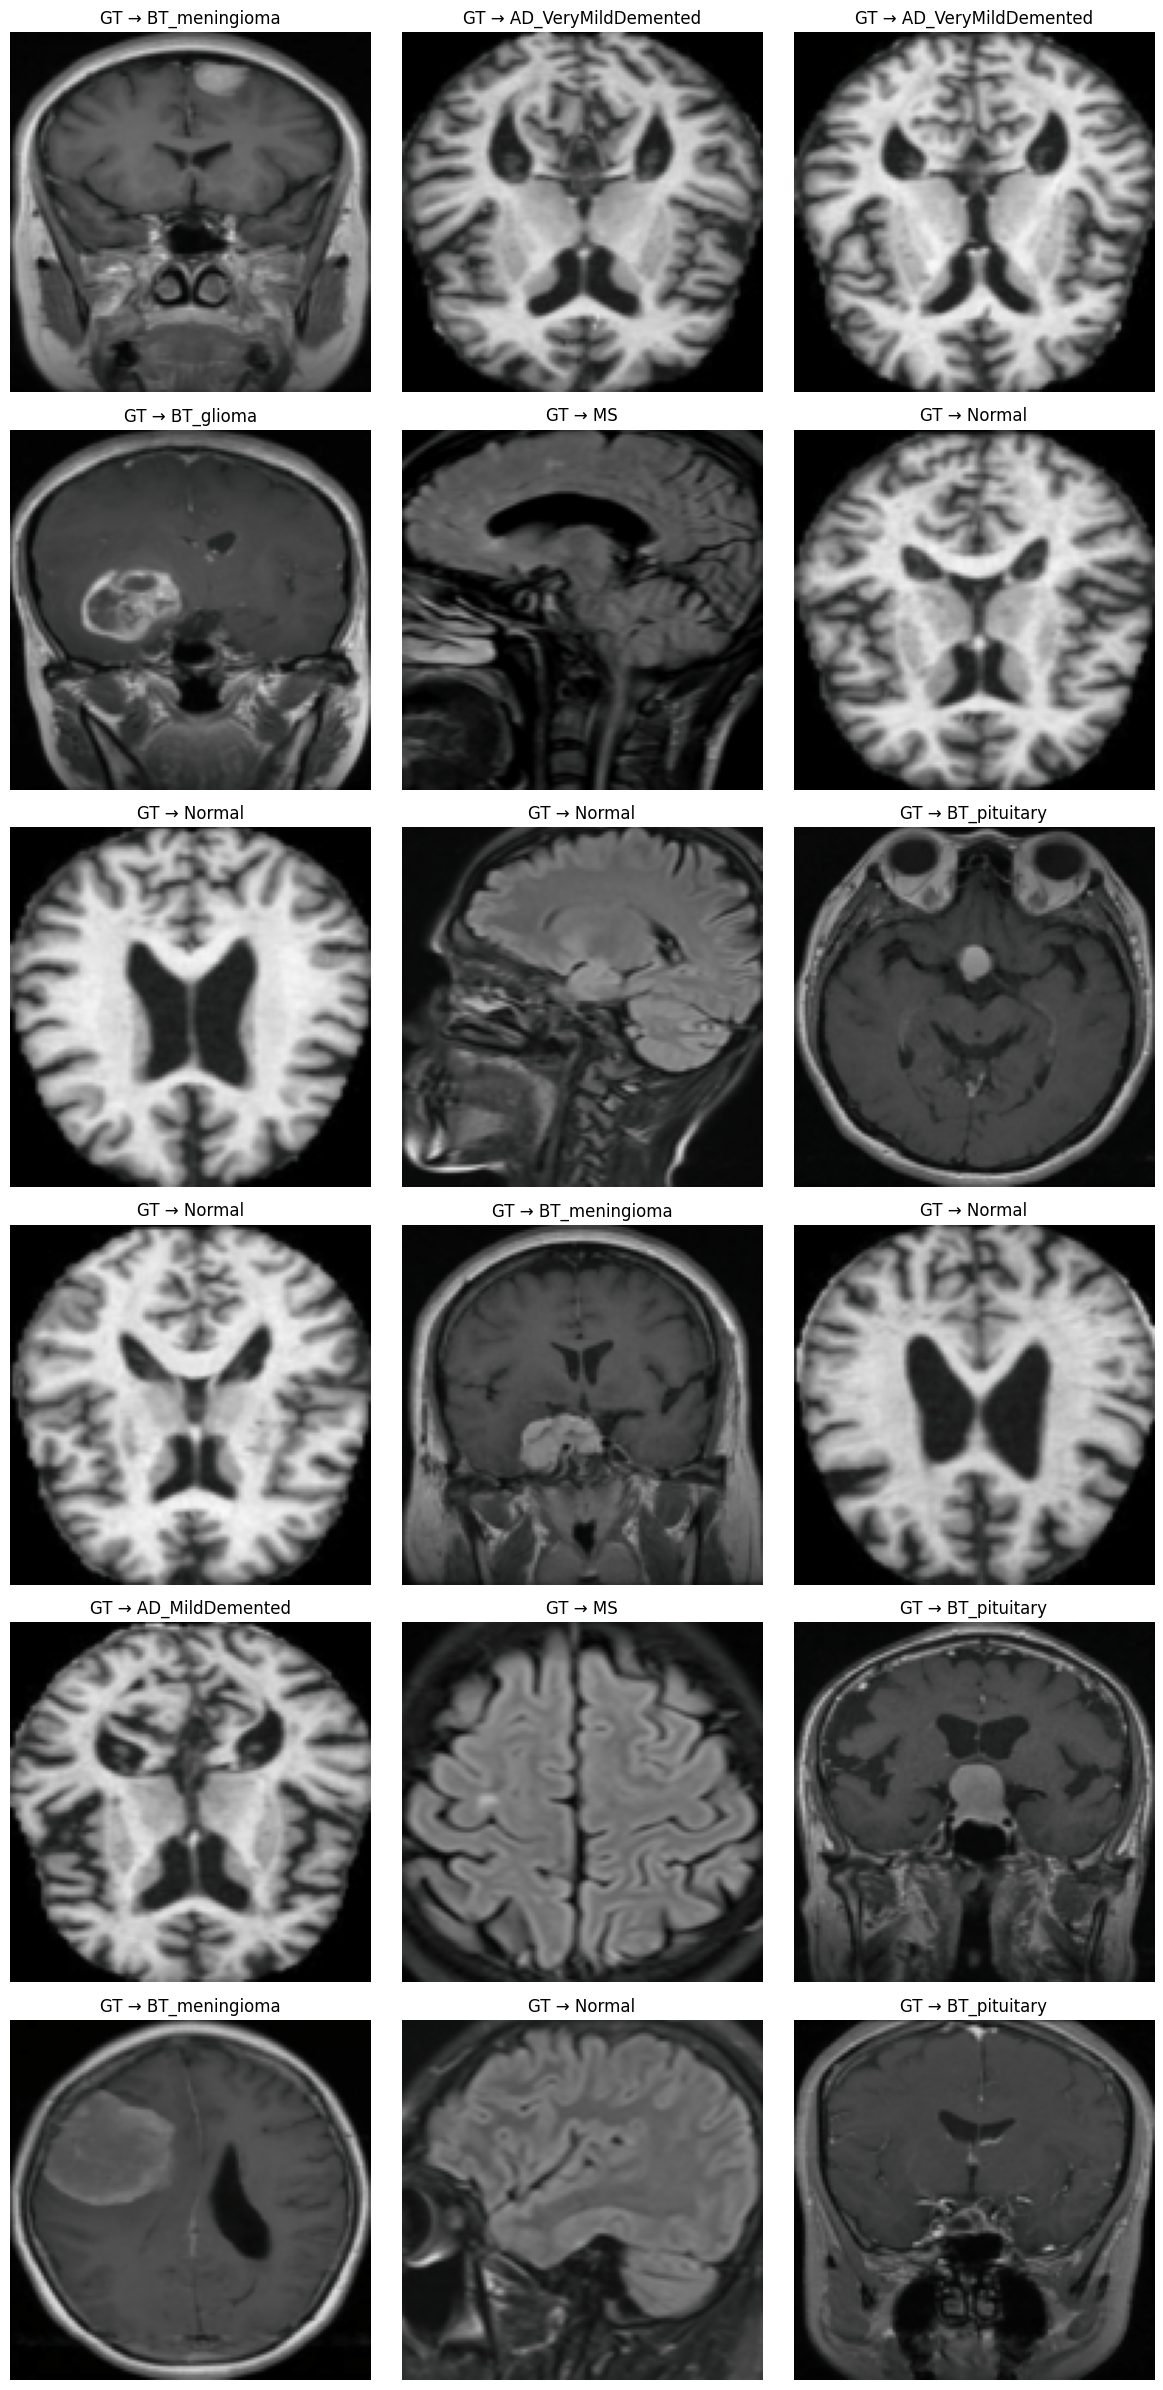

VAL Data Visualization in process...



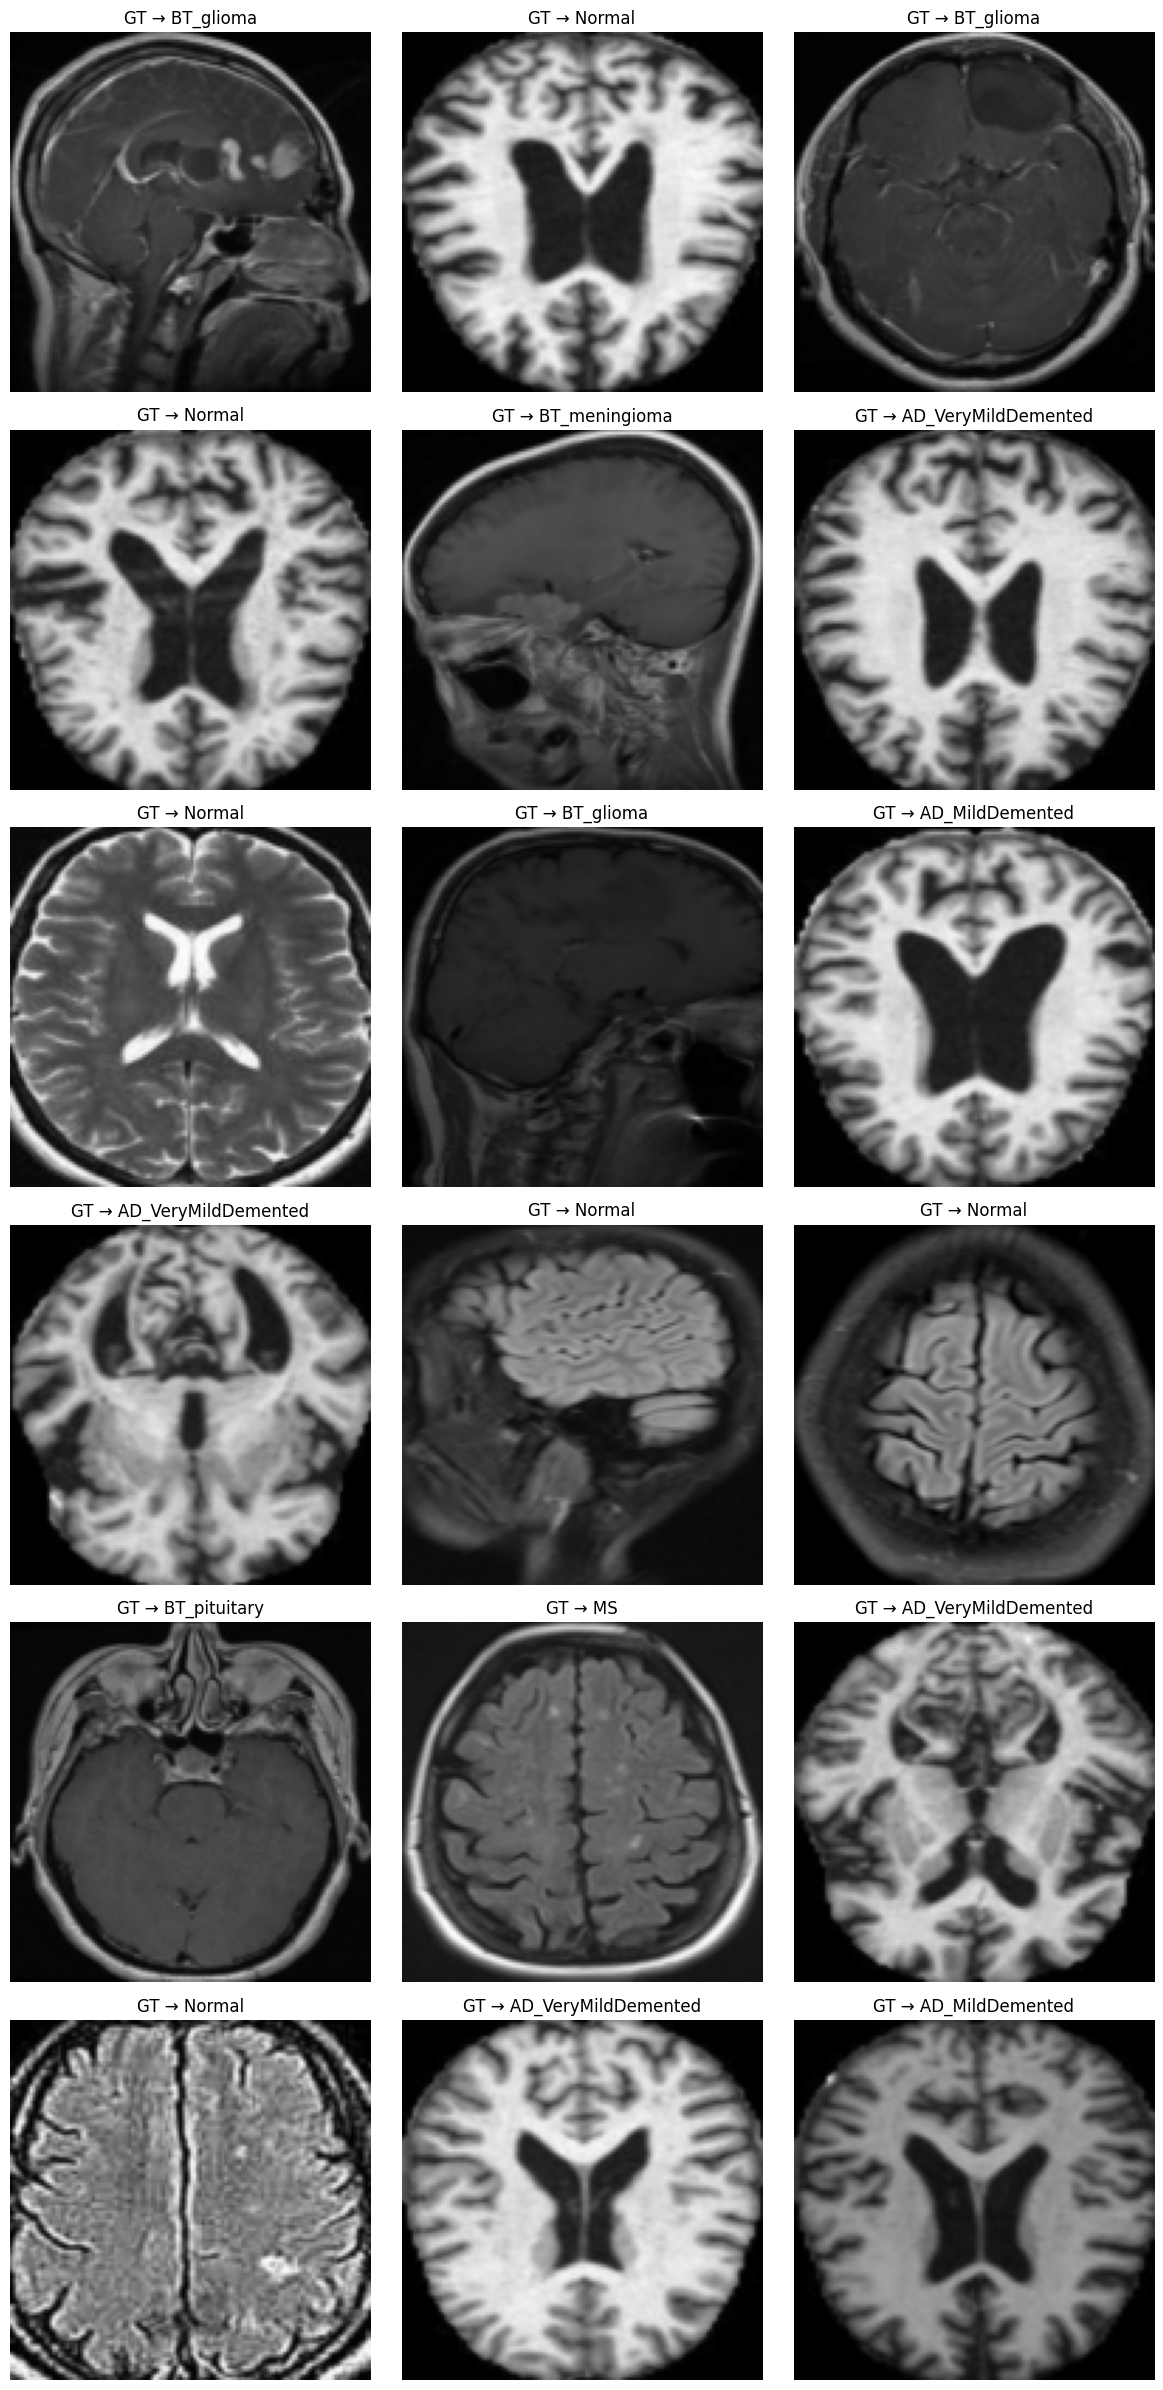

TEST Data Visualization in process...



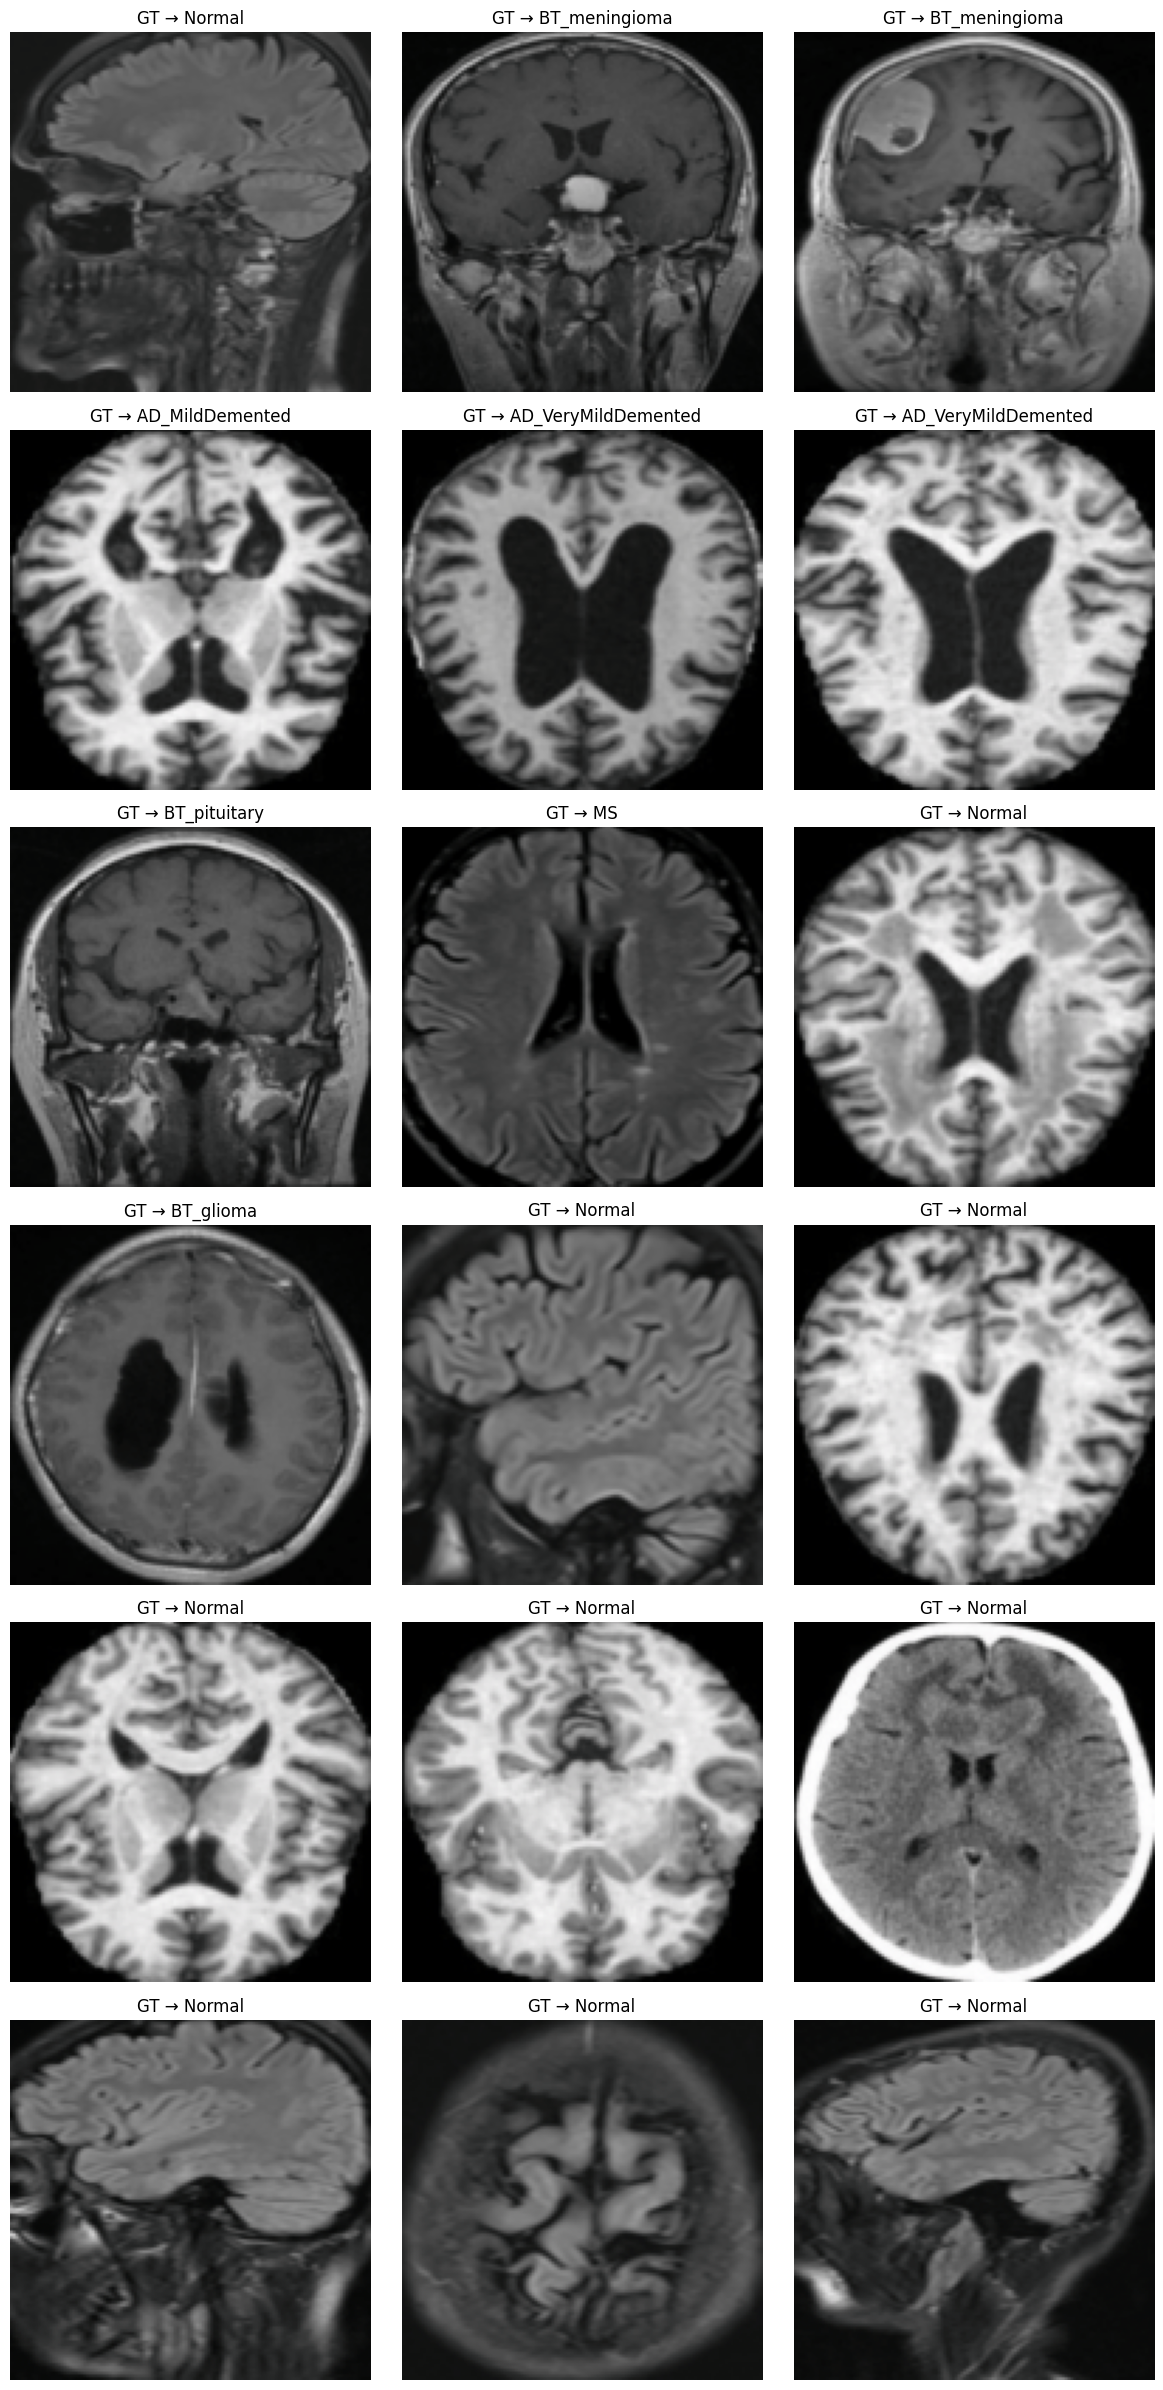

In [ ]:
# === USAGE ===
# Create visualization object and run plots
vis = Visualization(
    vis_dataloaders=[tr_dl, val_dl, ts_dl],
    n_images=18,
    rows=6,
    cmap="rgb",
    cls_names=list(classes.keys()),
    cls_counts=cls_counts
)

# vis.show_all_visualizations()
vis.show_all_visualizations()

Data analysis in process...



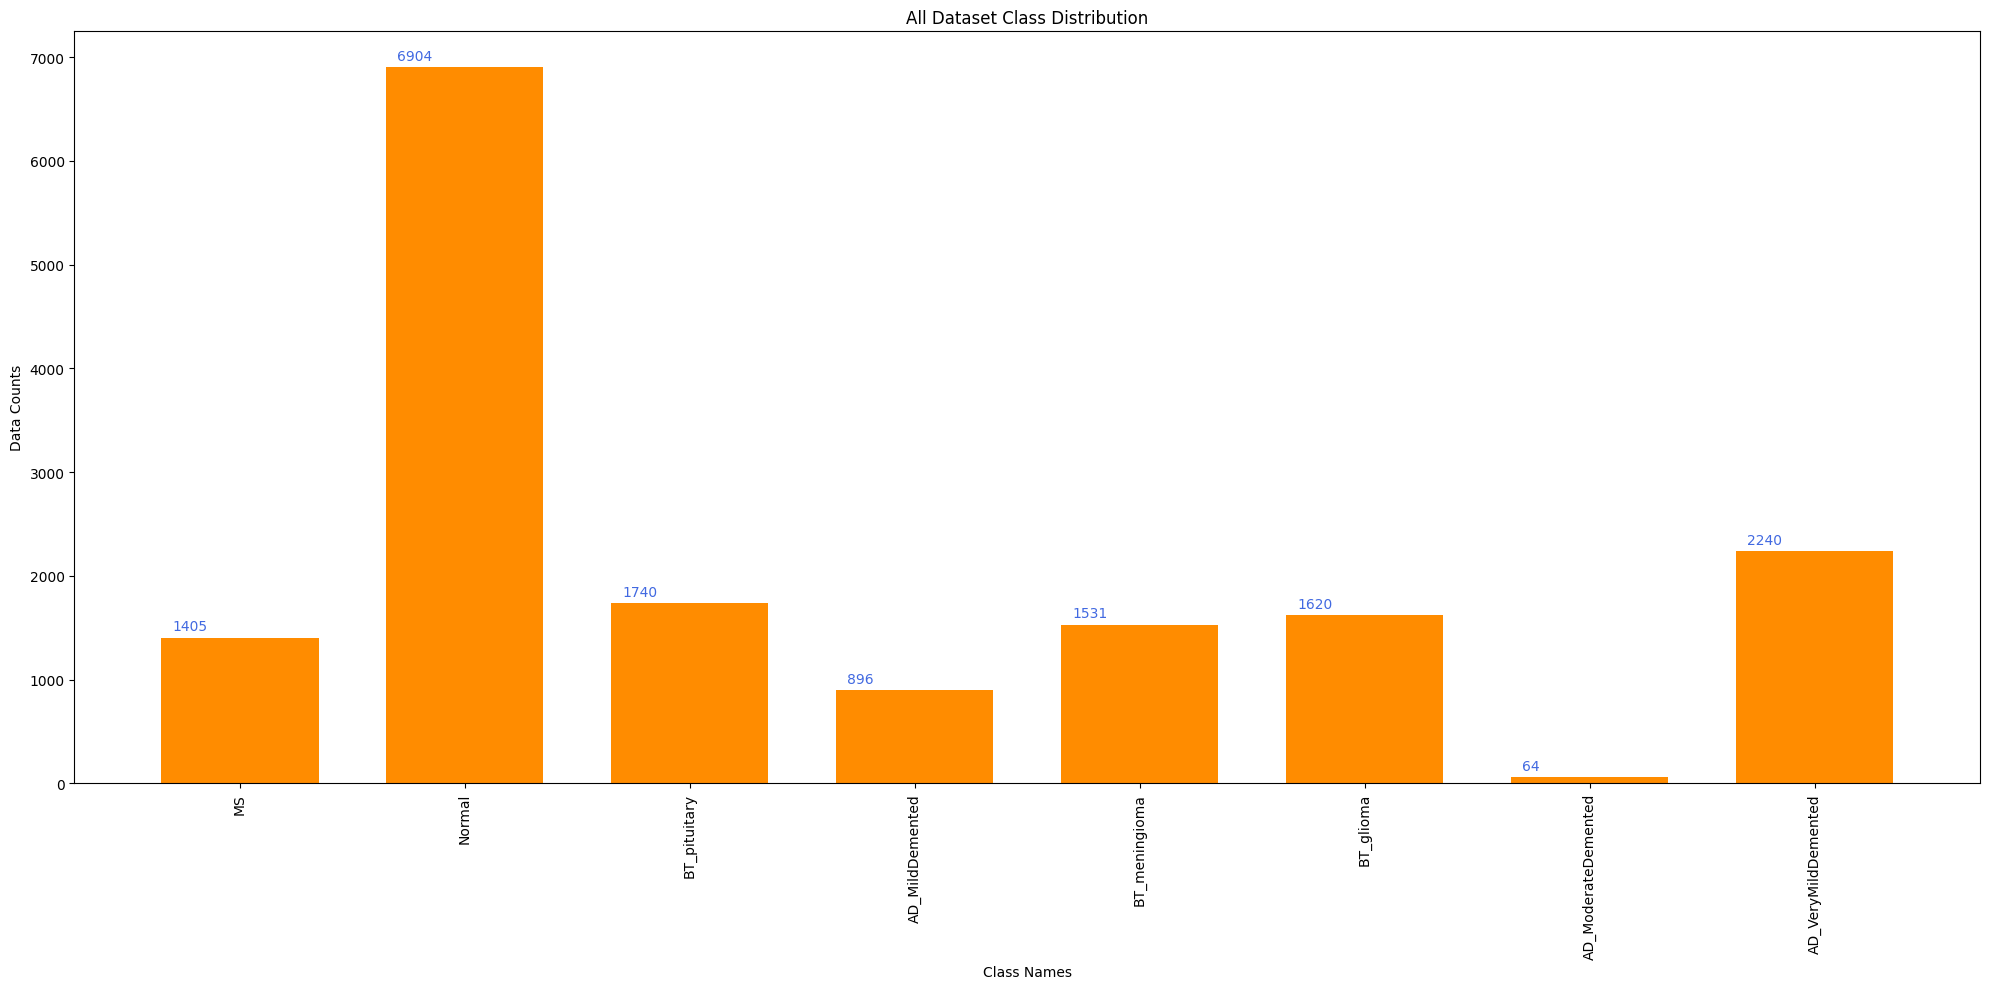

In [ ]:
# Display analysis results
vis.show_all_class_analysis()

Generating pie chart...



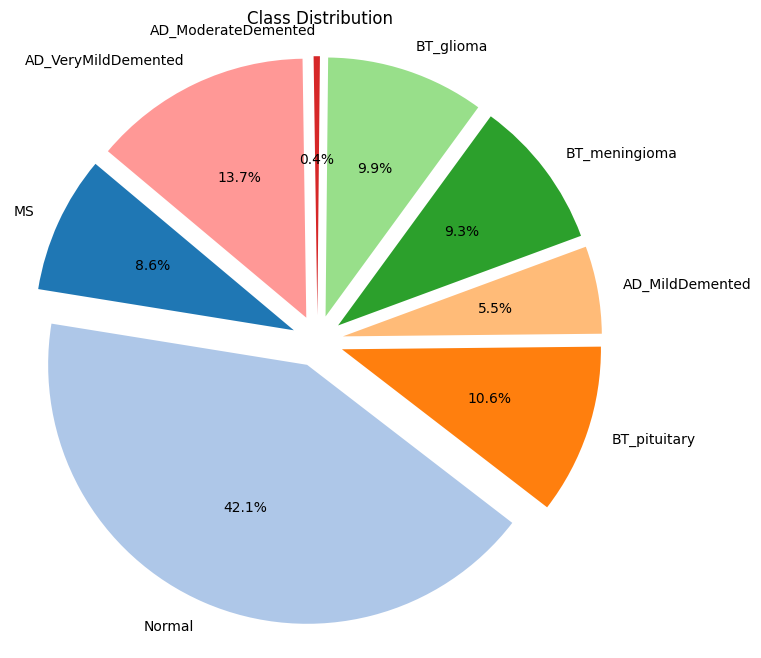

In [ ]:
# vis.show_pie_charts()
vis.show_pie_charts()

<div style='background-color: #f0f9e8; border: 3px solid #4CAF50; border-radius: 10px; padding: 8px; text-align: center;'>
    <font size="+2" color="#4CAF50"><b>✨ 4. AI Model Train and Validation ✨</b></font>
</div>

In [ ]:
!pip install torchmetrics
import os, torchmetrics
import timm
from tqdm import tqdm

class TrainValidation:
    def __init__(self, model_name, classes, tr_dl, val_dl, device, save_dir="saved_models", save_prefix="model", lr=3e-4, epochs=50, patience=5, threshold=0.01, dev_mode = False):
        self.model_name = model_name
        self.classes = classes
        self.tr_dl = tr_dl
        self.val_dl = val_dl
        self.save_dir = save_dir
        self.save_prefix = save_prefix
        self.lr = lr
        self.epochs = epochs
        self.patience = patience
        self.threshold = threshold
        self.dev_mode = dev_mode
        self.device = device
        self.model = timm.create_model(model_name, pretrained=True, num_classes=len(classes)).to(self.device)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(self.device)

        os.makedirs(save_dir, exist_ok=True)

        self.best_loss = float("inf")
        self.best_acc = 0
        self.not_improved = 0

        self.tr_losses, self.val_losses = [], []
        self.tr_accs, self.val_accs = [], []
        self.tr_f1s, self.val_f1s = [], []

    @staticmethod
    def to_device(batch, device):
        ims, gts = batch
        return ims.to(device), gts.to(device)

    def train_epoch(self):
        self.model.train()
        train_loss, train_acc = 0.0, 0.0
        self.f1_metric.reset()

        for idx, batch in tqdm(enumerate(self.tr_dl), desc="Training"):
            if self.dev_mode:
                if idx == 1: break

            ims, gts = TrainValidation.to_device(batch = batch, device = self.device)
            # ims, gts = self.to_device((ims, gts))

            # Forward pass
            preds = self.model(ims)
            loss = self.loss_fn(preds, gts)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update metrics
            train_loss += loss.item()
            train_acc += (torch.argmax(preds, dim=1) == gts).sum().item()
            self.f1_metric.update(preds, gts)

        train_loss /= len(self.tr_dl)
        train_acc /= len(self.tr_dl.dataset)
        train_f1 = self.f1_metric.compute().item()

        self.tr_losses.append(train_loss)
        self.tr_accs.append(train_acc)
        self.tr_f1s.append(train_f1)

        return train_loss, train_acc, train_f1

    def validate_epoch(self):
        self.model.eval()
        val_loss, val_acc = 0.0, 0.0
        self.f1_metric.reset()

        with torch.no_grad():
            for idx, batch in tqdm(enumerate(self.val_dl), desc="Validation"):
                if self.dev_mode:
                    if idx == 1: break
                # ims, gts = self.to_device((ims, gts))
                ims, gts = TrainValidation.to_device(batch, device = self.device)
                preds = self.model(ims)
                loss = self.loss_fn(preds, gts)

                # Update metrics
                val_loss += loss.item()
                val_acc += (torch.argmax(preds, dim=1) == gts).sum().item()
                self.f1_metric.update(preds, gts)

        val_loss /= len(self.val_dl)
        val_acc /= len(self.val_dl.dataset)
        val_f1 = self.f1_metric.compute().item()

        self.val_losses.append(val_loss)
        self.val_accs.append(val_acc)
        self.val_f1s.append(val_f1)

        return val_loss, val_acc, val_f1

    def save_best_model(self, val_f1, val_loss):
        if val_f1 > self.best_acc + self.threshold:
            self.best_acc = val_f1
            save_path = os.path.join(self.save_dir, f"{self.save_prefix}_best_model.pth")
            torch.save(self.model.state_dict(), save_path)
            print(f"Best model saved with F1-Score: {self.best_acc:.3f}")
            self.not_improved = 0
        else:
            self.not_improved += 1
            print(f"No improvement for {self.not_improved} epoch(s).")

    def verbose(self, epoch, metric1, metric2, metric3, process = "train"):

        print(f"{epoch + 1}-epoch {process} process is completed!\n")
        print(f"{epoch + 1}-epoch {process} loss          -> {metric1:.3f}")
        print(f"{epoch + 1}-epoch {process} accuracy      -> {metric2:.3f}")
        print(f"{epoch + 1}-epoch {process} f1-score      -> {metric3:.3f}\n")

    def run(self):
        print("Start training...")

        for epoch in range(self.epochs):
            if self.dev_mode:
                if epoch == 1: break

            print(f"\nEpoch {epoch + 1}/{self.epochs}:\n")

            train_loss, train_acc, train_f1 = self.train_epoch()
            self.verbose(epoch, train_loss, train_acc, train_f1, process = "train")

            val_loss, val_acc, val_f1 = self.validate_epoch()
            self.verbose(epoch, val_loss, val_acc, val_f1, process = "validation")

            self.save_best_model(val_f1, val_loss)

            if self.not_improved >= self.patience:
                print("Early stopping triggered.")
                break

model_name   = "rexnet_150"
save_prefix  = "brain"
save_dir     = "saved_models"
device       = "cuda" if torch.cuda.is_available() else "cpu"

trainer = TrainValidation(model_name = model_name, device = device,
                          save_prefix = save_prefix, classes = classes,
                          patience = 3, tr_dl = tr_dl, val_dl = val_dl, dev_mode = False)
trainer.run()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...

Epoch 1/50:



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 462it [37:54,  4.92s/it]

1-epoch train process is completed!

1-epoch train loss          -> 0.747
1-epoch train accuracy      -> 0.743
1-epoch train f1-score      -> 0.743




Validation: 26it [00:42,  1.64s/it]

1-epoch validation process is completed!

1-epoch validation loss          -> 0.325
1-epoch validation accuracy      -> 0.877
1-epoch validation f1-score      -> 0.877

Best model saved with F1-Score: 0.877

Epoch 2/50:




Training: 462it [37:22,  4.85s/it]

2-epoch train process is completed!

2-epoch train loss          -> 0.242
2-epoch train accuracy      -> 0.911
2-epoch train f1-score      -> 0.911




Validation: 26it [00:35,  1.38s/it]


2-epoch validation process is completed!

2-epoch validation loss          -> 0.266
2-epoch validation accuracy      -> 0.909
2-epoch validation f1-score      -> 0.909

Best model saved with F1-Score: 0.909

Epoch 3/50:



Training: 462it [37:27,  4.87s/it]

3-epoch train process is completed!

3-epoch train loss          -> 0.113
3-epoch train accuracy      -> 0.959
3-epoch train f1-score      -> 0.959




Validation: 3it [00:07,  2.35s/it]


KeyboardInterrupt: 

<div style='background-color: #fff0f5; border: 3px solid #FF69B4; border-radius: 10px; padding: 8px; text-align: center;'>
    <font size="+2" color="#FF1493"><b>😍 5. Learning Curves 😍</b></font>
</div>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class PlotLearningCurves:
    """
    Class to visualize training and validation metrics (loss, accuracy, F1-score) over epochs.
    """

    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        self.tr_losses = tr_losses
        self.val_losses = val_losses
        self.tr_accs = tr_accs
        self.val_accs = val_accs
        self.tr_f1s = tr_f1s
        self.val_f1s = val_f1s

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        """
        Plot two arrays with labels and colors.

        Args:
            array_1 (list): Data for the first line.
            array_2 (list): Data for the second line.
            label_1 (str): Label for the first line.
            label_2 (str): Label for the second line.
            color_1 (str): Color code for the first line.
            color_2 (str): Color code for the second line.
        """
        plt.plot(array_1, label=label_1, c=color_1, linewidth=2)
        plt.plot(array_2, label=label_2, c=color_2, linewidth=2)

    def create_figure(self):
        """Create a new matplotlib figure."""
        plt.figure(figsize=(10, 5))

    def decorate(self, ylabel, xlabel="Epochs"):
        """
        Set axis labels, ticks, legend, and show the plot.

        Args:
            ylabel (str): Label for the y-axis.
            xlabel (str): Label for the x-axis.
        """
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(ticks=np.arange(len(self.tr_accs)), labels=[i + 1 for i in range(len(self.tr_accs))])
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def visualize(self):
        """Generate all three learning curve plots: Loss, Accuracy, and F1 Score."""
        # Figure 1: Loss Curves
        self.create_figure()
        self.plot(
            array_1=self.tr_losses,
            array_2=self.val_losses,
            label_1="Train Loss",
            label_2="Validation Loss",
            color_1="#FF6347",    # Tomato
            color_2="#3CB371"     # MediumSeaGreen
        )
        self.decorate(ylabel="Loss")

        # Figure 2: Accuracy Curves
        self.create_figure()
        self.plot(
            array_1=self.tr_accs,
            array_2=self.val_accs,
            label_1="Train Accuracy",
            label_2="Validation Accuracy",
            color_1="#FF4500",    # OrangeRed
            color_2="#32CD32"     # LimeGreen
        )
        self.decorate(ylabel="Accuracy")

        # Figure 3: F1 Score Curves
        self.create_figure()
        self.plot(
            array_1=self.tr_f1s,
            array_2=self.val_f1s,
            label_1="Train F1 Score",
            label_2="Validation F1 Score",
            color_1="#8A2BE2",    # BlueViolet
            color_2="#DC143C"     # Crimson
        )
        self.decorate(ylabel="F1 Score")


<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
    <font size="+1.8" color="#FF4500"><b>✅ 6. Inference and AI Model Performance Analysis with GradCAM ✅</b></font>
</div>

In [ ]:
!pip install grad-cam==1.4.6
import cv2, random
import seaborn as sns
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

class Denormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Reverse the normalization applied to the image tensor.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

class ModelInferenceVisualizer:
    def __init__(self, model, device, class_names=None, im_size=224, mean = mean, std = std):

        self.denormalize = Denormalize(mean, std)
        self.model = model
        self.device = device
        self.class_names = class_names
        self.im_size = im_size
        self.model.eval()  # Set model to evaluation mode
        self.f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(self.device)

    def tensor_to_image(self, tensor):
        """
        Convert a normalized tensor to a denormalized image array.
        """
        tensor = self.denormalize(tensor)  # Denormalize the tensor
        tensor = tensor.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        return (tensor.cpu().numpy() * 255).astype(np.uint8)

    def plot_value_array(self, logits, gt, class_names):
        """Plot the prediction probability array."""
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1)

        plt.grid(visible=True)
        plt.xticks(range(len(class_names)), class_names, rotation='vertical')
        plt.yticks(np.arange(0.0, 1.1, 0.1))
        bars = plt.bar(range(len(class_names)), [p.item() for p in probs[0]], color="#777777")
        plt.ylim([0, 1])
        if pred_class.item() == gt:
            bars[pred_class].set_color('green')
        else:
            bars[pred_class].set_color('red')

    def generate_cam_visualization(self, image_tensor):
        """Generate GradCAM visualization."""
        cam = GradCAMPlusPlus(model=self.model, target_layers=[self.model.features[-1]], use_cuda=self.device == "cuda")
        grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0))[0, :]
        return grayscale_cam

    def infer_and_visualize(self, test_dl, num_images=5, rows=2):
        """Perform inference and visualize predictions along with GradCAM."""
        preds, images, lbls, logitss = [], [], [], []
        accuracy, count = 0, 1

        with torch.no_grad():
            for idx, batch in tqdm(enumerate(test_dl), desc="Inference"):
                im, gt = TrainValidation.to_device(batch, device=self.device)
                logits = self.model(im)
                pred_class = torch.argmax(logits, dim=1)

                accuracy += (pred_class == gt).sum().item()
                self.f1_metric.update(logits, gt)  # Do NOT reset inside the loop

                images.append(im[0])
                logitss.append(logits[0])
                preds.append(pred_class[0].item())
                lbls.append(gt[0].item())

        # Compute metrics AFTER the loop
        print(f"Accuracy of the model on the test data -> {(accuracy / len(test_dl.dataset)):.3f}")
        print(f"F1 score of the model on the test data -> {(self.f1_metric.compute().item()):.3f}")

        plt.figure(figsize=(20, 10))
        indices = [random.randint(0, len(images) - 1) for _ in range(num_images)]
        for idx, index in enumerate(indices):
            # Convert and denormalize image
            im = self.tensor_to_image(images[index].squeeze())
            pred_idx = preds[index]
            gt_idx = lbls[index]

            # Display image
            plt.subplot(rows, 2 * num_images // rows, count)
            count += 1
            plt.imshow(im, cmap="gray")
            plt.axis("off")

            # GradCAM visualization
            grayscale_cam = self.generate_cam_visualization(images[index])
            visualization = show_cam_on_image(im / 255, grayscale_cam, image_weight=0.4, use_rgb=True)
            plt.imshow(cv2.resize(visualization, (self.im_size, self.im_size), interpolation=cv2.INTER_LINEAR), alpha=0.7, cmap='jet')
            plt.axis("off")

            # Prediction probability array
            logits = logitss[index]
            if logits.dim() == 1:  # If 1D, add a batch dimension
                logits = logits.unsqueeze(0)
            plt.subplot(rows, 2 * num_images // rows, count)
            count += 1
            self.plot_value_array(logits=logits, gt=gt_idx, class_names=self.class_names)

            # Title with GT and Prediction
            if self.class_names:
                gt_name = self.class_names[gt_idx]
                pred_name = self.class_names[pred_idx]
                color = "green" if gt_name == pred_name else "red"
                plt.title(f"GT -> {gt_name} ; PRED -> {pred_name}", color=color)

        # Plot confusion matrix
        plt.figure(figsize=(20, 10))
        cm = confusion_matrix(lbls, preds)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

model = timm.create_model(model_name = model_name, pretrained = True, num_classes = len(classes)).to(device)
model.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
inference_visualizer = ModelInferenceVisualizer(
    model=model,
    device=device,
    class_names=list(classes.keys()),  # List of class names
    im_size=im_size
)

inference_visualizer.infer_and_visualize(ts_dl, num_images = 20, rows = 4)